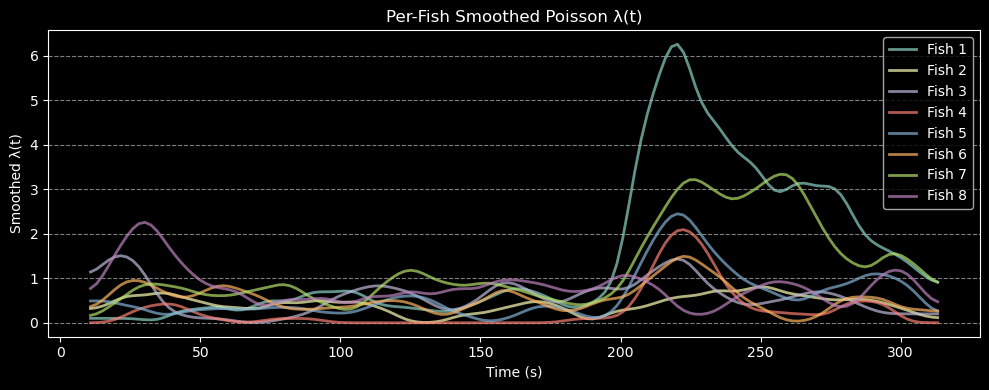

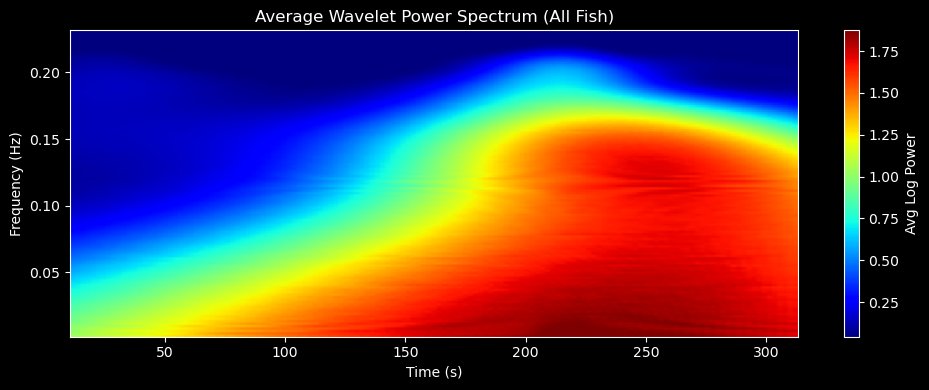

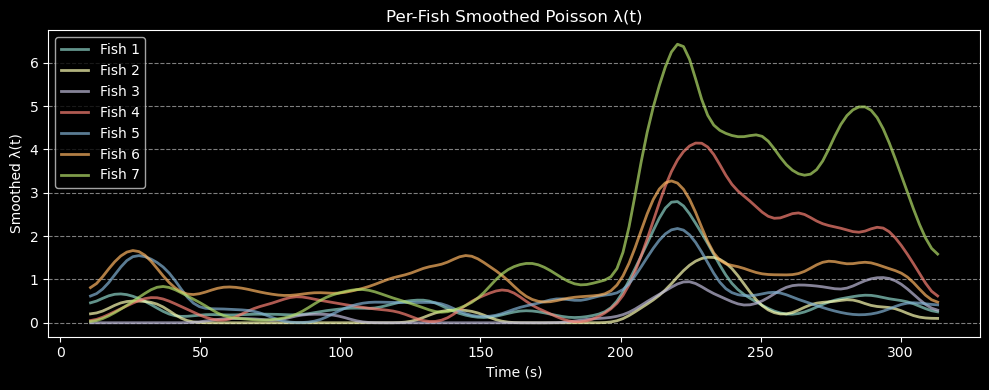

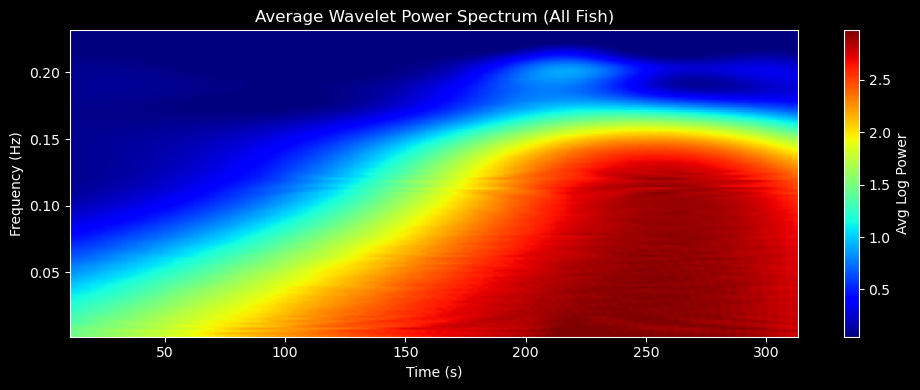

In [2]:
### Contrast Group
import numpy as np
import matplotlib.pyplot as plt
from Methods import stimuli, file_process
##############################
contrast_rig1_0727_path = "/Users/haotianli/Code/EngertLab/Data/20250727_rig1/stimulus_int_and_damp"
contrast_rig1_0727_stimulus_data_paths, contrast_rig1_0727_HT_data_paths = file_process.extract_from_stimuli(contrast_rig1_0727_path)
stimuli_rig1_0727_contrast = stimuli(contrast_rig1_0727_stimulus_data_paths, contrast_rig1_0727_HT_data_paths)

stimuli_rig1_0727_contrast_struggle, time_axes, avg_power_rig1_0727 = stimuli_rig1_0727_contrast.struggle_detection(threshold=100, mode="fish")


##############################
contrast_rig2_0727_path = "/Users/haotianli/Code/EngertLab/Data/20250727_rig2/stimulus_int_and_damp (1)"
contrast_rig2_0727_stimulus_data_paths, contrast_rig2_0727_HT_data_paths = file_process.extract_from_stimuli(contrast_rig2_0727_path)
stimuli_rig2_0727_contrast = stimuli(contrast_rig2_0727_stimulus_data_paths, contrast_rig2_0727_HT_data_paths)

stimuli_rig2_0727_contrast_struggle, _, avg_power_rig2_0727 = stimuli_rig2_0727_contrast.struggle_detection(threshold=100, mode="fish")




In [3]:
import numpy as np
import glob
import os
import sys

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import gaussian_kde
from scipy.ndimage import gaussian_filter1d
import pywt
import pycwt as wavelet
from scipy.signal import detrend



## Contrast Data Integration
contrast_data_struggle = stimuli_rig1_0727_contrast_struggle + stimuli_rig2_0727_contrast_struggle
print(contrast_data_struggle.shape)
# 栅格化原始时间轴
num_bins = 320
bins = np.linspace(time_axes.min(), time_axes.max(), num_bins + 1)
counts, bin_edges = np.histogram(time_axes, bins=bins, weights=contrast_data_struggle)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_width = bins[1] - bins[0]

# ==== 泊松 λ(t) 估计 ====
def sliding_poisson_lambda(counts, centers, window_size_bins=5, stride_bins=1):
    lambdas = []
    lambda_times = []
    for i in range(0, len(counts) - window_size_bins + 1, stride_bins):
        window = counts[i:i+window_size_bins]
        lam = np.mean(window) / bin_width  # 恢复为“单位时间 λ”
        center_time = np.mean(centers[i:i+window_size_bins])
        lambdas.append(lam)
        lambda_times.append(center_time)
    return np.array(lambda_times), np.array(lambdas)

# 滑动窗口 λ(t) 曲线
lambda_times, lambda_vals = sliding_poisson_lambda(counts, bin_centers, window_size_bins=10, stride_bins=1)
lambda_vals_smooth = gaussian_filter1d(lambda_vals, sigma=2)

# ==== 绘图 ====
plt.style.use('dark_background')
plt.figure(figsize=(10, 3))

# 原始计数柱状图
plt.bar(bin_centers, counts, width=np.diff(bin_edges), align='center', edgecolor='white', color='lightgray',
        alpha=0.4, label='Struggle Count')

# λ(t) 曲线（泊松滑动估计）
plt.plot(lambda_times, lambda_vals * bin_width, color='#D76C82', linewidth=2, label='Poisson λ(t)')

# Smoothed λ(t) 曲线（泊松滑动估计）
plt.plot(lambda_times, lambda_vals_smooth * bin_width, color='#99BC85', linewidth=2, label='Smoothed Poisson λ(t)')

plt.xlabel('Time (s)')
plt.ylabel('Struggle Count / Estimated Rate')
plt.title('Struggle Frequency with Poisson λ(t) Estimation (7 fish, each fish 18 trials)')
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.style.use('dark_background')
plt.show()

# ==== 输入信号 ====
signal = lambda_vals_smooth
t = lambda_times
dt = np.mean(np.diff(t))  # 时间步长（假设等间距）

# ==== 选择小波类型和尺度 ====
wavelet = 'cmor2.0-0.5'  # cmor[bandwidth parameter]-[center frequency]
scales = np.arange(1, 128)

# ==== 连续小波变换 ====    
coeffs, freqs = pywt.cwt(signal, scales, wavelet, sampling_period=dt)
power = np.abs(coeffs) ** 2

# ==== 可视化 ====
plt.figure(figsize=(10, 4))
plt.imshow(power, extent=[t[0], t[-1], freqs[-1], freqs[0]],
        cmap='jet', aspect='auto', vmin = np.percentile(power, 10), vmax = np.percentile(power, 99.5))
plt.colorbar(label='Log Power')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Wavelet Power Spectrum')
plt.tight_layout()
plt.show()

ValueError: operands could not be broadcast together with shapes (8,19437) (7,19439) 